### Network model of elderly home

Guido Vaessen (12488860) and Joos Akkerman (11304723)


Report for Introduction to Computational Science

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

#### Initialize nurse class

In [2]:
class Worker(object):
    
    def __init__(self, id, status):
        self.id   = id
        self.status = status
        self.connections_clients = []
        self.connections_workers  = []
        
        
    def __str__(self):
        return f'Worker {self.id}, status: {self.status}'

#### Initialize client class

In [3]:
class Client(object):
    
    def __init__(self, id, status):
        self.id   = id
        self.status = status
        self.connections_clients = []
        self.connections_workers  = []
        
    def __str__(self):
        return f'Client {self.id}, status: {self.status}'

#### Initialize network class

In [4]:
class Network(object):
    
    def __init__(self, id, n_workers, n_clients, clients_to_clients, workers_to_clients, workers_to_workers):
        self.id        = id
        self.workers   = []
        self.clients   = []
        self.all_I     = []
        self.wor_I     = []
        self.cli_I     = []
        self.n_workers = n_workers
        self.n_clients = n_clients
        self.clients_to_clients = clients_to_clients
        self.workers_to_clients = workers_to_clients
        self.workers_to_workers = workers_to_workers
        
        # metrics for network
        self.avg_degree    = 0
        self.cluster_coeff = 0
        self.diameter      = 0
        self.degree_centr  = 0
        self.between_centr = 0
        self.close_centr   = 0
        
        
    def init_workers_clients(self):
        """
        Initializes workers and clients
        """
        for worker in range(self.n_workers):
            self.workers += [Worker(worker, 'S')]

        for client in range(self.n_clients):
            self.clients += [Client(client, 'S')]
    
    def connect_workers_clients(self):
        """
        Connects workers and clients
        """             
        
        # PROBLEM: stops, gets into infinite loop
        # connect workers to each other
#         unconnected_workers = [i for i in self.workers]
        for worker in self.workers:
            while len(worker.connections_workers) < self.workers_to_workers:
                
                colleague = np.random.choice(self.workers) 
                while colleague in worker.connections_workers:
                    colleague = np.random.choice(self.workers)
                    
                if ((worker != colleague) and (colleague not in worker.connections_workers)):
                    colleague.connections_workers += [worker]
                    worker.connections_workers += [colleague]
                    
#                 if len(colleague.connections_workers) >= self.workers_to_workers:
#                     unconnected_workers.remove(colleague)
                
#                 if len(worker.connections_workers) >= self.workers_to_workers:
#                     unconnected_workers.remove(worker)
#                     break
                
                        
        # connect clients to each other
#         unconnected_clients = [i for i in self.clients]
        for client in self.clients:
            while len(client.connections_clients) < self.clients_to_clients:

                other_client = np.random.choice(self.clients)
                while other_client in client.connections_clients and client != other_client:
                    other_client = np.random.choice(self.clients)

                other_client.connections_clients += [client]
                client.connections_clients += [other_client]
                    
#                 if len(client.connections_clients) >= self.clients_to_clients:
#                     unconnected_clients.remove(client)
#                     break
                        
        # connect workers to clients         
        for client in self.clients:
            worker_connections = list(np.random.choice(self.workers, size=self.workers_to_clients, replace=False))
            client.connections_workers += worker_connections
            for worker in worker_connections:
                worker.connections_clients += [client]
        
        
    def __str__(self):
        return f'Network {self.id}, n of workers: {len(self.workers)}, n of clients: {len(self.clients)}.'

#### Initialize population

In [5]:
def init_network(id, n_workers, n_clients, clients_to_clients, workers_to_clients, workers_to_workers):
    """
    Initializes network object and worker and client objects
    """
    network = Network(1, n_workers, n_clients, clients_to_clients, workers_to_clients, workers_to_workers)
    
    # create worker and client nodes
    network.init_workers_clients()
    
    # connect worker and client nodes
    network.connect_workers_clients()
    
    return network

#### Create graph object, inject data from network object

In [6]:
def upload_network(network):
    G = nx.Graph()
    node_color_map = []
    edge_color_map = []

    # add nodes to graph
    for worker in network.workers:
        G.add_node(f'w{worker.id}')
        if worker.status == 'I':
            node_color_map += ['red']
        else:
            node_color_map += ['blue']

    for client in network.clients:
        G.add_node(f'c{client.id}')
        if client.status == 'I':
            node_color_map += ['red']
        else:
            node_color_map += ['green']

    # add edges between nodes
    for worker in network.workers:
        for colleague in worker.connections_workers:
            G.add_edge(f'w{worker.id}', f'w{colleague.id}')
            edge_color_map += ['black']

    for client in network.clients:
        for worker in client.connections_workers:
            G.add_edge(f'c{client.id}', f'w{worker.id}')
            edge_color_map += ['red']
        
        for otherclient in client.connections_clients:
            G.add_edge(f'c{client.id}', f'c{otherclient.id}')
            edge_color_map += ['orange']
    
    return G, node_color_map

In [7]:
def update_network_metrics(G, network):
    """
    Updates network metrics
    """
    network.avg_degree    = nx.average_neighbor_degree(G)
    network.cluster_coeff = nx.algorithms.cluster.average_clustering(G)
    network.diameter      = nx.diameter(G)
    network.degree_centr  = nx.algorithms.centrality.degree_centrality(G)
    network.between_centr = nx.algorithms.centrality.betweenness_centrality(G)
    network.close_centr   = nx.algorithms.centrality.closeness_centrality(G)

In [8]:
def reset_network(network):
    """
    Set population back to initial values
    """
    for indiv in network.all_I:
        indiv.status = 'S'

    network.all_I = []
    network.wor_I = []
    network.cli_I = []
    
    G, node_color_map = upload_network(network)
    
    return G, node_color_map

#### Create First Network

average degree: 6.645833333333333
[('w0', 40), ('w1', 54), ('w2', 42), ('w3', 37), ('w4', 47), ('w5', 50), ('w6', 41), ('w7', 36), ('w8', 42), ('w9', 40), ('w10', 39), ('w11', 48), ('c0', 7), ('c1', 6), ('c2', 8), ('c3', 7), ('c4', 9), ('c5', 8), ('c6', 9), ('c7', 8), ('c8', 7), ('c9', 8), ('c10', 6), ('c11', 6), ('c12', 6), ('c13', 10), ('c14', 7), ('c15', 6), ('c16', 6), ('c17', 8), ('c18', 6), ('c19', 6), ('c20', 6), ('c21', 6), ('c22', 7), ('c23', 7), ('c24', 6), ('c25', 7), ('c26', 6), ('c27', 6), ('c28', 6), ('c29', 8), ('c30', 7), ('c31', 7), ('c32', 8), ('c33', 6), ('c34', 6), ('c35', 8), ('c36', 6), ('c37', 6), ('c38', 6), ('c39', 8), ('c40', 6), ('c41', 6), ('c42', 7), ('c43', 7), ('c44', 7), ('c45', 6), ('c46', 8), ('c47', 7), ('c48', 6), ('c49', 6), ('c50', 6), ('c51', 6), ('c52', 6), ('c53', 7), ('c54', 6), ('c55', 6), ('c56', 8), ('c57', 7), ('c58', 6), ('c59', 9), ('c60', 8), ('c61', 9), ('c62', 6), ('c63', 6), ('c64', 6), ('c65', 6), ('c66', 6), ('c67', 8), ('c68', 7), 

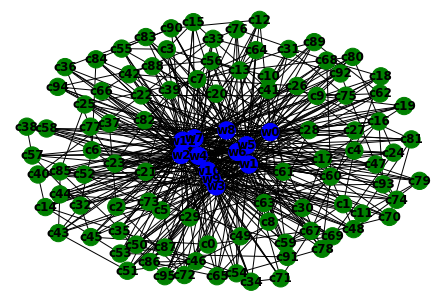

In [9]:
# set population parameters
n_workers = 12
n_clients = n_workers*8
# n_clients = 5
clients_to_clients = 2
workers_to_clients = 4
workers_to_workers = n_workers - 1
# workers_to_workers = 2
levels = 4

def create_network(n_workers, n_clients, clients_to_clients, workers_to_clients, workers_to_workers):

    # initialize network and draw
    network = init_network(1, n_workers, n_clients, clients_to_clients, workers_to_clients, workers_to_workers)
    G, node_color_map = upload_network(network)
    update_network_metrics(G, network)

    return network, G, node_color_map
    
network, G, node_color_map = create_network(n_workers, n_clients, clients_to_clients, workers_to_clients, workers_to_workers)
nx.draw(G, with_labels=True, node_color=node_color_map, font_weight='bold')

tot_degrees = 0
for client in network.clients:
    tot_degrees += (len(client.connections_clients)+len(client.connections_workers))
avg_degree = tot_degrees/len(network.clients)

print(f'average degree: {avg_degree}')
print(G.degree())

#### Propagate disease through population

fraction infected: 0.03125
[('w0', 45), ('w1', 38), ('w2', 41), ('w3', 39), ('w4', 42), ('w5', 47), ('w6', 43), ('w7', 44), ('w8', 38), ('w9', 45), ('w10', 49), ('w11', 45), ('c0', 9), ('c1', 10), ('c2', 10), ('c3', 12), ('c4', 11), ('c5', 13), ('c6', 10), ('c7', 9), ('c8', 10), ('c9', 10), ('c10', 11), ('c11', 9), ('c12', 10), ('c13', 10), ('c14', 8), ('c15', 8), ('c16', 12), ('c17', 10), ('c18', 10), ('c19', 11), ('c20', 9), ('c21', 12), ('c22', 13), ('c23', 9), ('c24', 9), ('c25', 9), ('c26', 8), ('c27', 12), ('c28', 12), ('c29', 11), ('c30', 8), ('c31', 9), ('c32', 9), ('c33', 10), ('c34', 9), ('c35', 9), ('c36', 10), ('c37', 8), ('c38', 9), ('c39', 10), ('c40', 8), ('c41', 8), ('c42', 8), ('c43', 8), ('c44', 10), ('c45', 8), ('c46', 11), ('c47', 9), ('c48', 9), ('c49', 9), ('c50', 9), ('c51', 9), ('c52', 9), ('c53', 8), ('c54', 9), ('c55', 8), ('c56', 9), ('c57', 8), ('c58', 10), ('c59', 9), ('c60', 10), ('c61', 8), ('c62', 8), ('c63', 9), ('c64', 8), ('c65', 8), ('c66', 9), ('c67

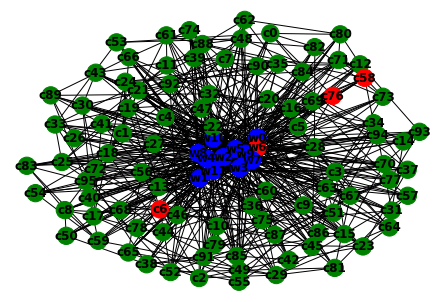

In [11]:
# set population parameters
n_workers = 12
n_clients = n_workers*8
clients_to_clients = 4
workers_to_clients = 4
workers_to_workers = n_workers - 1

# Disease parameters:
beta_wc = 0.15
beta_ww = 0.06
beta_cc = 0.02

def propagate_disease(network, G, beta_wc, beta_ww, beta_cc, p_test=0):
    
    # reset population
    G, node_color_map = reset_network(network)

    # randomly infect one worker
    sick_worker = np.random.choice(network.workers)
    sick_worker.status = 'I'
    network.all_I += [sick_worker]
    network.wor_I += [sick_worker]


    # let infection spread through population
    new_disease = [sick_worker]
    while len(new_disease) != 0:

        got_infected = []
        for indiv in new_disease:
                

            # change beta based on class individual
            beta_w = beta_ww
            beta_c = beta_wc
            if indiv in network.clients:
                beta_w = beta_wc
                beta_c = beta_cc
                
            for worker in indiv.connections_workers:
                if np.random.uniform() < beta_w and worker.status != 'I':
                    worker.status = 'I'
                    network.all_I += [worker]
                    network.wor_I += [worker]
                    got_infected += [worker]

            for client in indiv.connections_clients:
                if np.random.uniform() < beta_c and client.status != 'I':
                    client.status = 'I'
                    network.all_I += [client]
                    network.cli_I += [client]
                    got_infected += [client]

        # update new disease list
        new_disease = got_infected

    G, node_color_map = upload_network(network)
    update_network_metrics(G, network)
    
    return G, node_color_map

del network
del G
network, G, node_color_map = create_network(n_workers, n_clients, clients_to_clients, workers_to_clients, workers_to_workers)
G, node_color_map = propagate_disease(network, G, beta_wc, beta_ww, beta_cc)

frac_inf = len(network.cli_I)/len(network.clients)
print(f'fraction infected: {frac_inf}')

print(G.degree())

nx.draw(G, with_labels=True, node_color=node_color_map, font_weight='bold')

In [13]:
def change_param_network(beta_wc, beta_ww, beta_cc, clients_to_clients, workers_to_clients, workers_to_workers):
    """
    Changes parameters in network
    """
    
    # delete old connections between clients
    for client in network.clients:
        client.connections_clients = []
        client.connections_workers = []
        
    # delete old connections between workers
    for worker in network.workers:
        worker.connections_clients
        worker.connections_workers = []

    network.connect_workers_clients()

## Experiment 1: changing interaction parameters

Let the interaction parameters between clients and between workers change, see the effect on the total fraction of infected clients and workers. First test for different levels of worker interaction.

In [14]:
# set population parameters
n_workers = 10
n_clients = n_workers*8
clients_to_clients = 4
workers_to_clients = 4
workers_to_workers = n_workers - 1

# # Disease parameters:
# beta_wc = 0.1
# beta_ww = 0.05
# beta_cc = 0.05

# iterate over differing interaction values
contacts_between_clients = range(1,9)

frac_I_1 = {'workers':{i:[] for i in contacts_between_clients}, 'clients':{i:[] for i in contacts_between_clients}}
for i in contacts_between_clients:
    for j in range(30):
        del network
        network, G, node_color_map = create_network(n_workers, n_clients, i, workers_to_clients, workers_to_workers)
        propagate_disease(network, G, beta_wc, beta_ww, beta_cc)
        
        frac_I_1['workers'][i] += [round(len(network.wor_I)/len(network.workers),3)]
        frac_I_1['clients'][i] += [round(len(network.cli_I)/len(network.clients),3)]

In [16]:
# plot workers:
worker_avg_contc = np.array([np.average(frac_I_1['workers'][i]) for i in contacts_between_clients])
worker_std_contc = np.array([np.std(frac_I_1['workers'][i]) for i in contacts_between_clients])

client_avg_contc = np.array([np.average(frac_I_1['clients'][i]) for i in contacts_between_clients])
client_std_contc = np.array([np.std(frac_I_1['clients'][i]) for i in contacts_between_clients])



Now test for worker interaction:

In [15]:
# # Disease parameters:
# beta_wc = 0.1
# beta_ww = 0.05
# beta_cc = 0.05

# # set population parameters
# n_workers = 10
# n_clients = n_workers*8
# clients_to_clients = 4
# workers_to_clients = 4
# workers_to_workers = n_workers - 1 

# iterate over differing interaction values
contacts_between_workers = range(1, n_workers)

frac_I_2 = {'workers':{i:[] for i in contacts_between_workers}, 'clients':{i:[] for i in contacts_between_workers}}
for i in contacts_between_workers:
    for j in range(30):
        
        del network
        network, G, node_color_map = create_network(n_workers, n_clients, clients_to_clients, workers_to_clients, i)
        propagate_disease(network, G, beta_wc, beta_ww, beta_cc)
        
        frac_I_2['workers'][i] += [round(len(network.wor_I)/len(network.workers),3)]
        frac_I_2['clients'][i] += [round(len(network.cli_I)/len(network.clients),3)]

In [17]:
# plot workers:
worker_avg_contw = np.array([np.average(frac_I_2['workers'][i]) for i in contacts_between_workers])
worker_std_contw = np.array([np.std(frac_I_2['workers'][i]) for i in contacts_between_workers])

client_avg_contw = np.array([np.average(frac_I_2['clients'][i]) for i in contacts_between_workers])
client_std_contw = np.array([np.std(frac_I_2['clients'][i]) for i in contacts_between_workers])



In [18]:
network, G, node_color_map = create_network(n_workers, n_clients, clients_to_clients, workers_to_clients, workers_to_workers)

# iterate over differing interaction values
contacts_between_clients_workers = range(1,8)

frac_I_6 = {'workers':{i:[] for i in contacts_between_clients_workers}, 'clients':{i:[] for i in contacts_between_clients_workers}}
for i in contacts_between_clients_workers:
    for j in range(30):
        del network
        network, G, node_color_map = create_network(n_workers, n_clients, clients_to_clients, i, workers_to_workers)
        propagate_disease(network, G, beta_wc, beta_ww, beta_cc)
        
        frac_I_6['workers'][i] += [round(len(network.wor_I)/len(network.workers),3)]
        frac_I_6['clients'][i] += [round(len(network.cli_I)/len(network.clients),3)]

In [19]:
# plot workers:
worker_avg_contwc = np.array([np.average(frac_I_6['workers'][i]) for i in contacts_between_clients_workers])
worker_std_contwc = np.array([np.std(frac_I_6['workers'][i]) for i in contacts_between_clients_workers])

client_avg_contwc = np.array([np.average(frac_I_6['clients'][i]) for i in contacts_between_clients_workers])
client_std_contwc = np.array([np.std(frac_I_6['clients'][i]) for i in contacts_between_clients_workers])

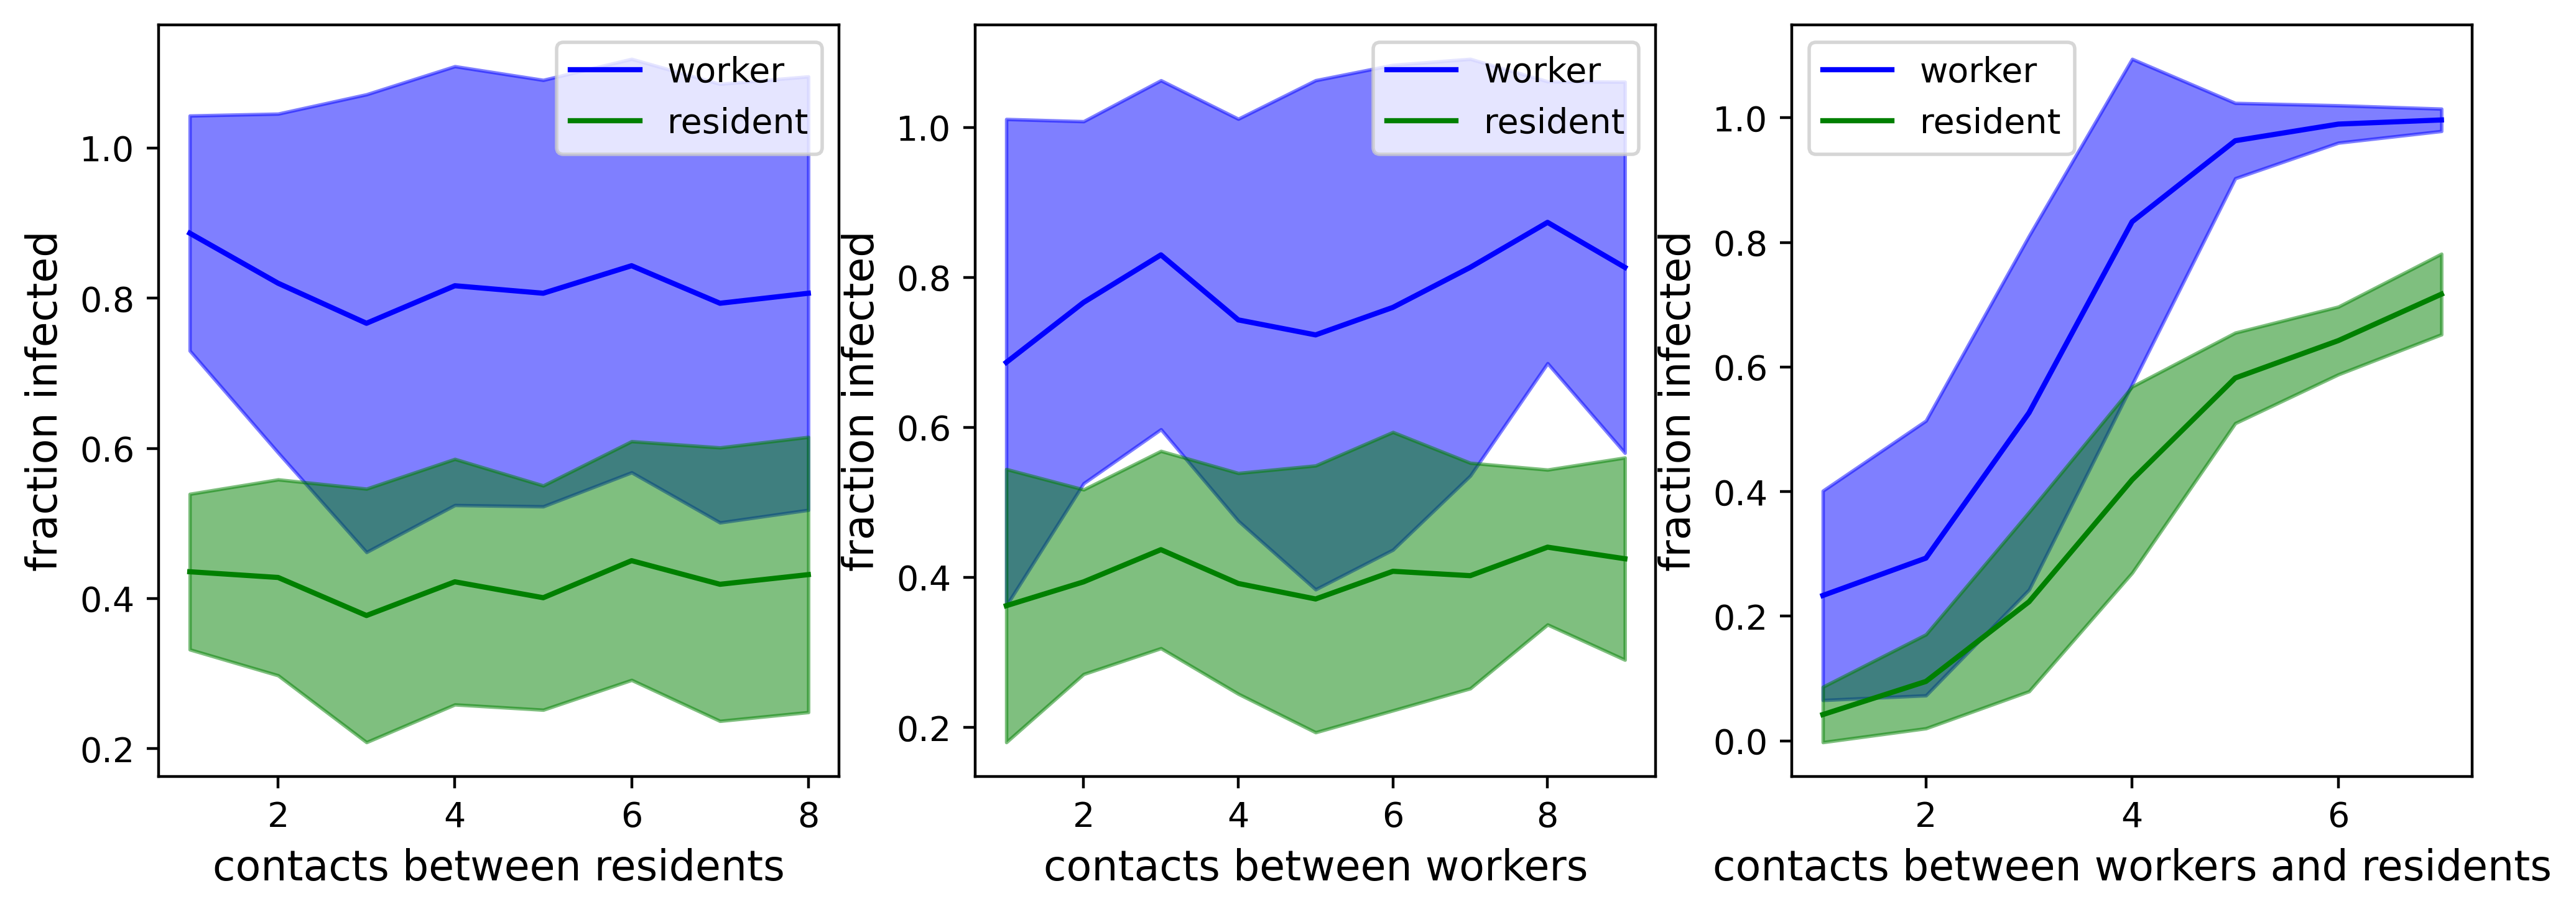

In [20]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4), dpi=400)

ax1.plot(contacts_between_clients, worker_avg_contc, color='blue', label='worker')
ax1.fill_between(contacts_between_clients, worker_avg_contc-worker_std_contc, worker_avg_contc+worker_std_contc, color='blue', alpha=0.5)
ax1.plot(contacts_between_clients, client_avg_contc, color='green', label='resident')
ax1.fill_between(contacts_between_clients, client_avg_contc-client_std_contc, client_avg_contc+client_std_contc, color='green', alpha=0.5)
ax1.set_xlabel('contacts between residents', fontsize=12)
ax1.set_ylabel('fraction infected', fontsize=12)
ax1.legend()

ax2.plot(contacts_between_workers, worker_avg_contw, color='blue', label='worker')
ax2.fill_between(contacts_between_workers, worker_avg_contw-worker_std_contw, worker_avg_contw+worker_std_contw, color='blue', alpha=0.5)
ax2.plot(contacts_between_workers, client_avg_contw, color='green', label='resident')
ax2.fill_between(contacts_between_workers, client_avg_contw-client_std_contw, client_avg_contw+client_std_contw, color='green', alpha=0.5)
ax2.set_xlabel('contacts between workers', fontsize = 12)
ax2.set_ylabel('fraction infected', fontsize = 12)
ax2.legend()

ax3.plot(contacts_between_clients_workers, worker_avg_contwc, color='blue', label='worker')
ax3.fill_between(contacts_between_clients_workers, worker_avg_contwc-worker_std_contwc, worker_avg_contwc+worker_std_contwc, color='blue', alpha=0.5)
ax3.plot(contacts_between_clients_workers, client_avg_contwc, color='green', label='resident')
ax3.fill_between(contacts_between_clients_workers, client_avg_contwc-client_std_contwc, client_avg_contwc+client_std_contwc, color='green', alpha=0.5)
ax3.set_xlabel('contacts between workers and residents', fontsize = 12)
ax3.set_ylabel('fraction infected', fontsize = 12)
ax3.legend()

plt.savefig('allcontacts_frac.pdf')
plt.show()

### Experiment 2: change infection rates

Assume extensive measures are taken to limit infection (protective measures like masks, gloves etc.)

In [21]:
# # Disease parameters:
# beta_wc = 0.1
# beta_ww = 0.05
# beta_cc = 0.05

# # set population parameters
# n_workers = 10
# n_clients = n_workers*8
# clients_to_clients = 4
# workers_to_clients = 4
# workers_to_workers = n_workers - 1 

# iterate over differing interaction values
# contacts_between_workers = range(1, n_workers)
# betas_wc = np.arange(0.01, 0.55, 0.05)
betas_wc = np.logspace(-2, -0.3, num = 10)

frac_I_3 = {'workers':{i:[] for i in betas_wc}, 'clients':{i:[] for i in betas_wc}}
for i in betas_wc:
    for j in range(30):
        
        del network
        network, G, node_color_map = create_network(n_workers, n_clients, clients_to_clients, workers_to_clients, workers_to_workers)
        propagate_disease(network, G, i, beta_ww, beta_cc)
        
        frac_I_3['workers'][i] += [round(len(network.wor_I)/len(network.workers),3)]
        frac_I_3['clients'][i] += [round(len(network.cli_I)/len(network.clients),3)]

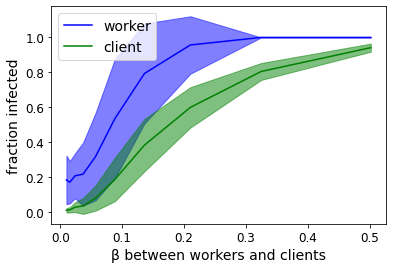

In [44]:
# plot workers:
worker_avg_wc = np.array([np.average(frac_I_3['workers'][i]) for i in betas_wc])
worker_std_wc = np.array([np.std(frac_I_3['workers'][i]) for i in betas_wc])

client_avg_wc = np.array([np.average(frac_I_3['clients'][i]) for i in betas_wc])
client_std_wc = np.array([np.std(frac_I_3['clients'][i]) for i in betas_wc])

plt.plot(betas_wc, worker_avg_wc, color='blue', label='worker')
plt.fill_between(betas_wc, worker_avg_wc - worker_std_wc, worker_avg_wc + worker_std_wc, color='blue', alpha=0.5)
plt.plot(betas_wc, client_avg_wc, color='green', label='client')
plt.fill_between(betas_wc, client_avg_wc-client_std_wc, client_avg_wc+client_std_wc, color='green', alpha=0.5)
plt.xlabel('\u03B2 between workers and clients', fontsize = 14)
plt.ylabel('fraction infected', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 14)
plt.savefig('infected_betawc_frac.pdf')
plt.show()

check for beta between workers

In [23]:
# # Disease parameters:
# beta_wc = 0.1
# beta_ww = 0.05
# beta_cc = 0.05

# # set population parameters
# n_workers = 10
# n_clients = n_workers*8
# clients_to_clients = 4
# workers_to_clients = 4
# workers_to_workers = n_workers - 1 

# iterate over differing interaction values
# contacts_between_workers = range(1, n_workers)
# betas_ww = np.arange(0.05, 0.55, 0.05)
betas_ww = np.logspace(-2, -0.3, num = 10)

frac_I_4 = {'workers':{i:[] for i in betas_ww}, 'clients':{i:[] for i in betas_ww}}
for i in betas_ww:
    for j in range(30):
        
        del network
        network, G, node_color_map = create_network(n_workers, n_clients, clients_to_clients, workers_to_clients, workers_to_workers)
        propagate_disease(network, G, beta_wc, i, beta_cc)
        
        frac_I_4['workers'][i] += [round(len(network.wor_I)/len(network.workers),3)]
        frac_I_4['clients'][i] += [round(len(network.cli_I)/len(network.clients),3)]

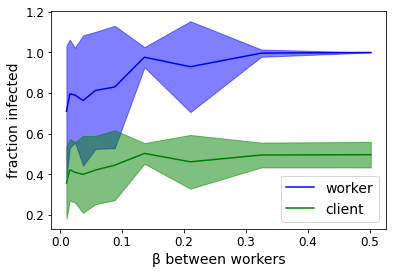

In [47]:
# plot workers:
worker_avg_ww = np.array([np.average(frac_I_4['workers'][i]) for i in betas_ww])
worker_std_ww = np.array([np.std(frac_I_4['workers'][i]) for i in betas_ww])

client_avg_ww = np.array([np.average(frac_I_4['clients'][i]) for i in betas_ww])
client_std_ww = np.array([np.std(frac_I_4['clients'][i]) for i in betas_ww])

plt.plot(betas_ww, worker_avg_ww, color='blue', label='worker')
plt.fill_between(betas_ww, worker_avg_ww-worker_std_ww, worker_avg_ww+worker_std_ww, color='blue', alpha=0.5)
plt.plot(betas_ww, client_avg_ww, color='green', label='client')
plt.fill_between(betas_ww, client_avg_ww-client_std_ww, client_avg_ww+client_std_ww, color='green', alpha=0.5)
plt.xlabel('\u03B2 between workers', fontsize = 14)
plt.ylabel('fraction infected', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 14)
plt.savefig('infected_betaww_frac.pdf')
plt.show()

check for beta between clients

In [25]:
# # Disease parameters:
# beta_wc = 0.1
# beta_ww = 0.05
# beta_cc = 0.05

# # set population parameters
# n_workers = 10
# n_clients = n_workers*8
# clients_to_clients = 4
# workers_to_clients = 4
# workers_to_workers = n_workers - 1 

# iterate over differing interaction values
# contacts_between_workers = range(1, n_workers)

# betas_cc = np.arange(0.01, 0.55, 0.05)
betas_cc = np.logspace(-2, -0.3, num = 10)

frac_I_5 = {'workers':{i:[] for i in betas_cc}, 'clients':{i:[] for i in betas_cc}}
for i in betas_cc:
    for j in range(30):
        
        del network
        network, G, node_color_map = create_network(n_workers, n_clients, clients_to_clients, workers_to_clients, workers_to_workers)
        propagate_disease(network, G, beta_wc, beta_ww, i)
        
        frac_I_5['workers'][i] += [round(len(network.wor_I)/len(network.workers),3)]
        frac_I_5['clients'][i] += [round(len(network.cli_I)/len(network.clients),3)]

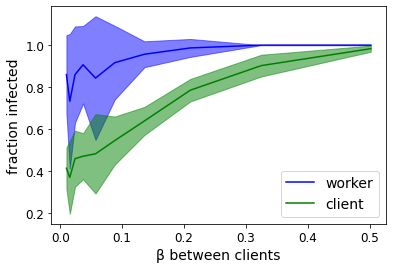

In [50]:
# plot workers:
worker_avg_cc = np.array([np.average(frac_I_5['workers'][i]) for i in betas_cc])
worker_std_cc = np.array([np.std(frac_I_5['workers'][i]) for i in betas_cc])

client_avg_cc = np.array([np.average(frac_I_5['clients'][i]) for i in betas_cc])
client_std_cc = np.array([np.std(frac_I_5['clients'][i]) for i in betas_cc])

plt.plot(betas_cc, worker_avg_cc, color='blue', label='worker')
plt.fill_between(betas_cc, worker_avg_cc-worker_std_cc, worker_avg_cc+worker_std_cc, color='blue', alpha=0.5)
plt.plot(betas_cc, client_avg_cc, color='green', label='client')
plt.fill_between(betas_cc, client_avg_cc-client_std_cc, client_avg_cc+client_std_cc, color='green', alpha=0.5)
plt.xlabel('\u03B2 between clients', fontsize = 14)
plt.ylabel('fraction infected', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 14)
plt.savefig('infected_betacc_frac.pdf')
plt.show()

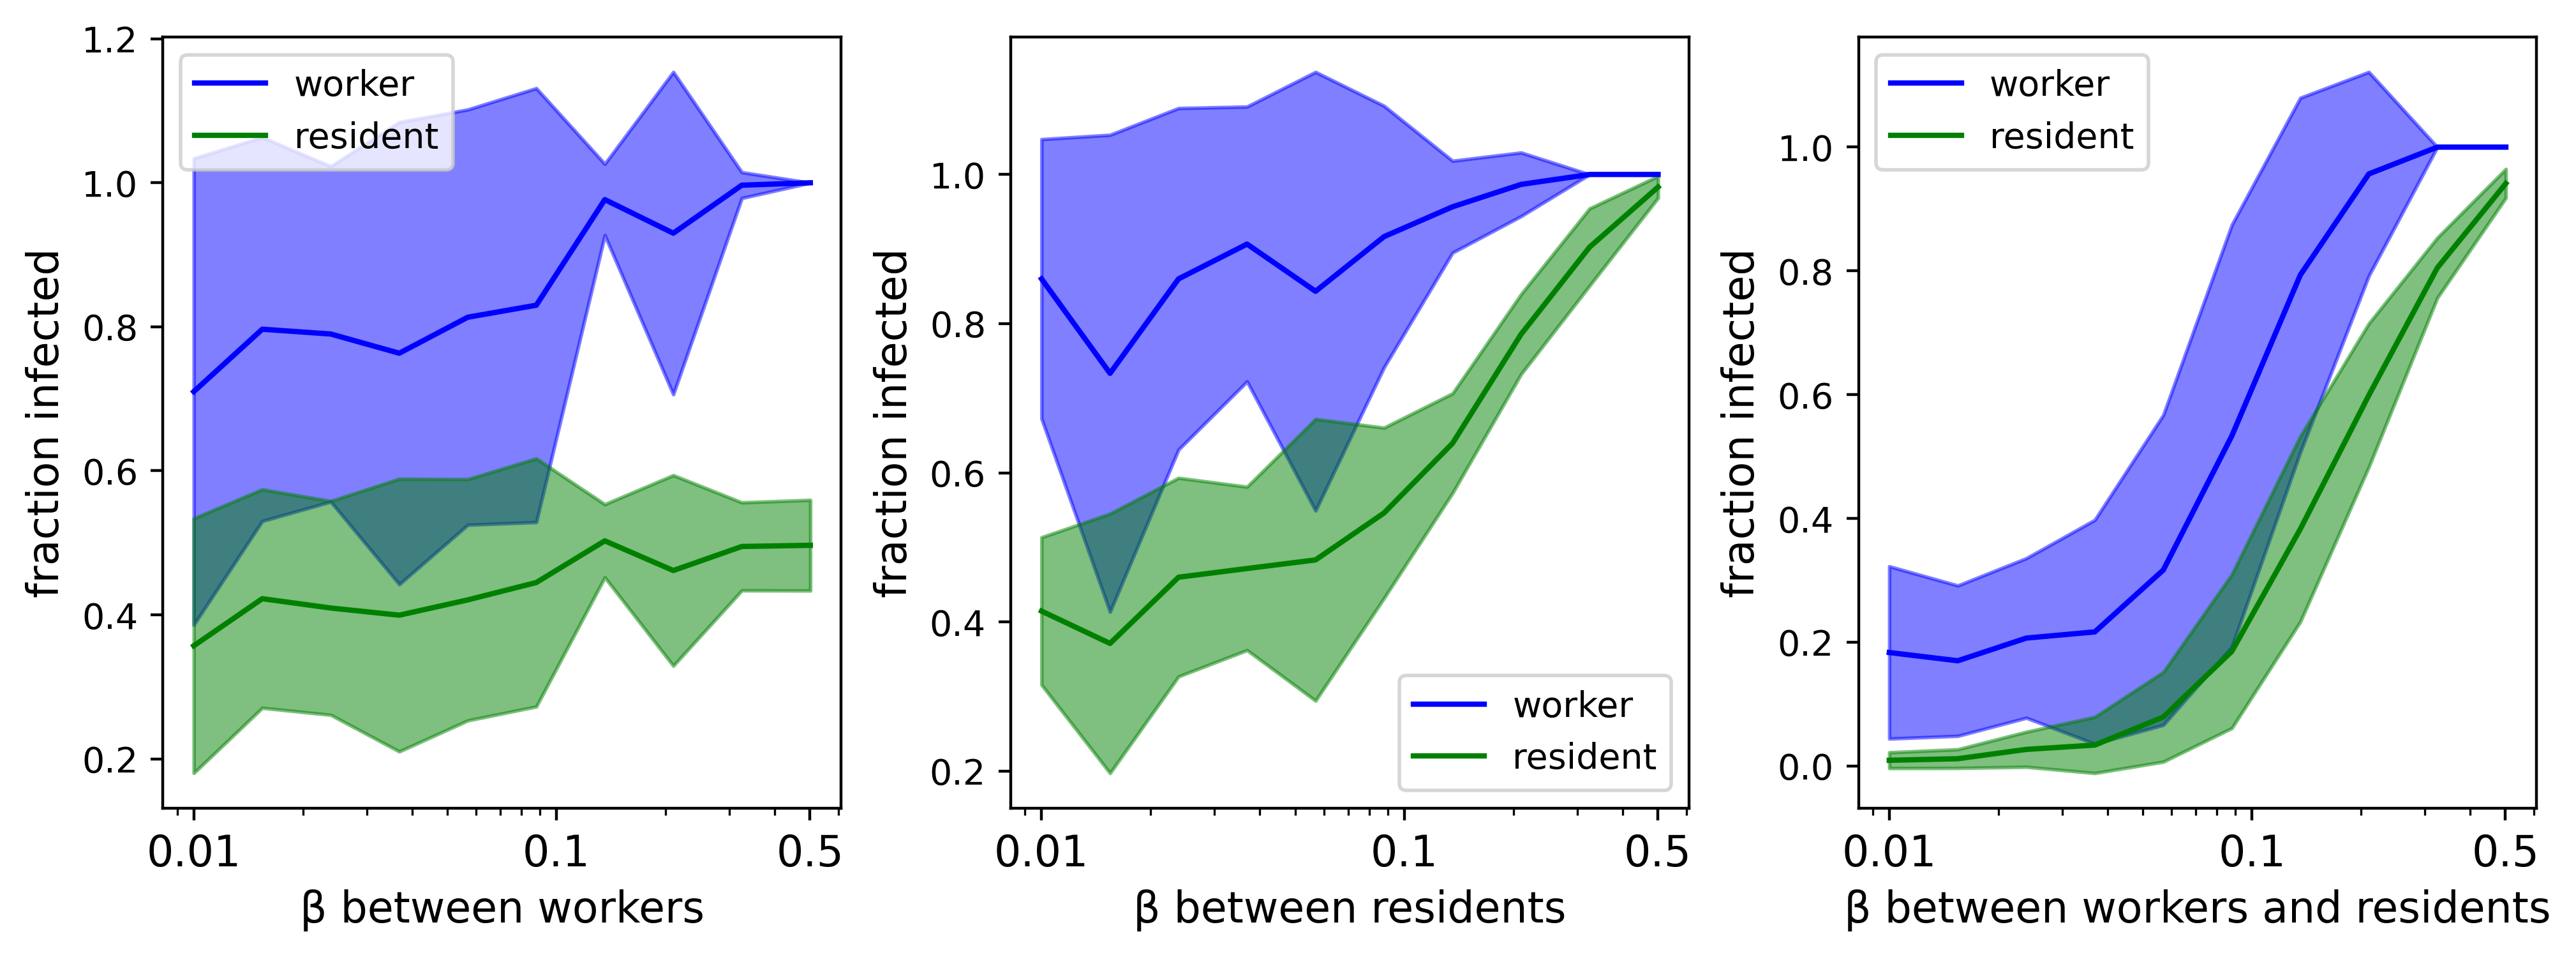

In [51]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4), dpi=400)

ax1.plot(betas_ww, worker_avg_ww, color='blue', label='worker')
ax1.fill_between(betas_ww, worker_avg_ww-worker_std_ww, worker_avg_ww+worker_std_ww, color='blue', alpha=0.5)
ax1.plot(betas_ww, client_avg_ww, color='green', label='resident')
ax1.fill_between(betas_ww, client_avg_ww-client_std_ww, client_avg_ww+client_std_ww, color='green', alpha=0.5)
ax1.set_xlabel('\u03B2 between workers', fontsize = 12)
ax1.set_ylabel('fraction infected', fontsize = 12)
ax1.set_xscale('log')
ax1.set_xticks([0.01,0.1,0.5]) 
ax1.set_xticklabels([0.01,0.1,0.5], fontsize=12)
ax1.legend(loc='upper left')

ax2.plot(betas_cc, worker_avg_cc, color='blue', label='worker')
ax2.fill_between(betas_wc, worker_avg_cc-worker_std_cc, worker_avg_cc+worker_std_cc, color='blue', alpha=0.5)
ax2.plot(betas_cc, client_avg_cc, color='green', label='resident')
ax2.fill_between(betas_cc, client_avg_cc-client_std_cc, client_avg_cc+client_std_cc, color='green', alpha=0.5)
ax2.set_xlabel('\u03B2 between residents', fontsize = 12)
ax2.set_ylabel('fraction infected', fontsize = 12)
ax2.set_xscale('log')
ax2.set_xticks([0.01,0.1,0.5]) 
ax2.set_xticklabels([0.01,0.1,0.5], fontsize=12)
ax2.legend(loc='lower right')

ax3.plot(betas_wc, worker_avg_wc, color='blue', label='worker')
ax3.fill_between(betas_wc, worker_avg_wc-worker_std_wc, worker_avg_wc+worker_std_wc, color='blue', alpha=0.5)
ax3.plot(betas_wc, client_avg_wc, color='green', label='resident')
ax3.fill_between(betas_wc, client_avg_wc-client_std_wc, client_avg_wc+client_std_wc, color='green', alpha=0.5)
ax3.set_xlabel('\u03B2 between workers and residents', fontsize = 12)
ax3.set_ylabel('fraction infected', fontsize = 12)
ax3.set_xscale('log')
ax3.set_xticks([0.01,0.1,0.5]) 
ax3.set_xticklabels([0.01,0.1,0.5], fontsize=12)
ax3.legend()

plt.subplots_adjust(wspace=0.25)
plt.savefig('infected_allbeta.pdf', dpi=300)
plt.show()

#### Experiment 3: chance of discovery

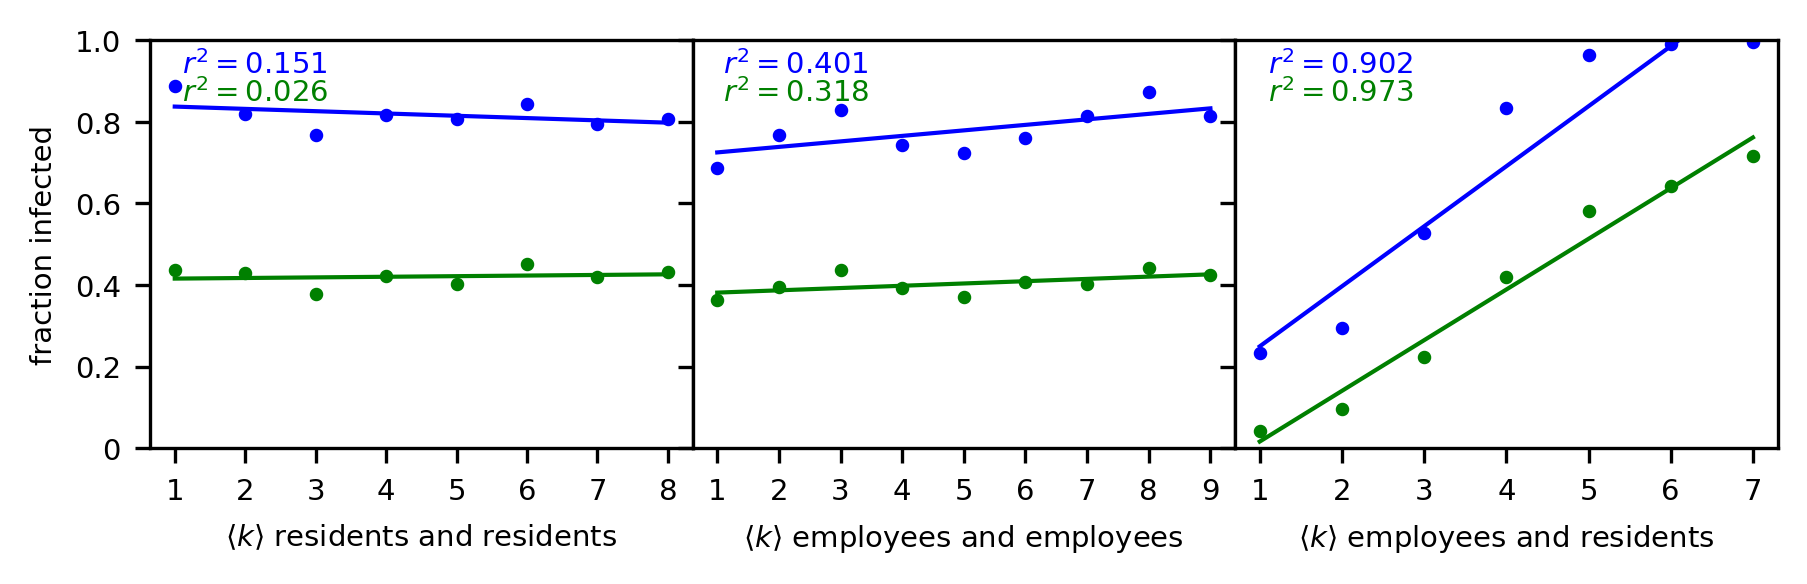

In [136]:
from sklearn.linear_model import LinearRegression
from matplotlib.offsetbox import AnchoredText

def linear_regression(x_data, y_data):
    # reshape 1D data for some reason
    x_data = np.array(x_data).reshape(-1, 1)
    y_data = np.array(y_data).reshape(-1, 1)
    
    regression = LinearRegression().fit(x_data, y_data)
    
    return regression.predict(x_data), regression.score(x_data, y_data)
   

def plot_regres(xdata, ydata_w, ydata_c, ax=None, xpos=(1.1, 1.1), ypos=(0.92, 0.85), **plt_kwargs):
    if ax is None:
        plt.gca()
       
    inf_predict_w, r2w = linear_regression(xdata, ydata_w)
    inf_predict_c, r2c = linear_regression(xdata, ydata_c)

    ax.scatter(xdata, ydata_w, color='blue', s=5)
    ax.plot(xdata, inf_predict_w, color='blue', lw=1)
    ax.scatter(xdata, ydata_c, color='green', s=5)
    ax.plot(xdata, inf_predict_c, color='green', lw=1)

    ax.text(xpos[0], ypos[0], rf'$r^2 = {round(r2w, 3)}$', color='blue', fontsize=7)
    ax.text(xpos[1], ypos[1], rf'$r^2 = {round(r2c, 3)}$', color='green', fontsize=7)
    ax.set_ylim(0, 1)
    
    return ax


fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(7, 2), dpi=300, sharey=True) 

ax1 = plot_regres(contacts_between_clients, worker_avg_contc, client_avg_contc, ax=ax1)
ax1.set_xticks(np.arange(1, max(contacts_between_clients)+1, 1, dtype=int))
ax1.set_xticklabels(np.arange(1, max(contacts_between_clients)+1, 1, dtype=int), fontsize=7)
ax1.set_xlabel(r'$\langle k \rangle$ residents and residents', fontsize=7)
ax1.set_yticks(np.arange(0, 1.1, 0.2))
ax1.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=7)
ax1.set_ylabel('fraction infected', fontsize=7)

ax2 = plot_regres(contacts_between_workers, worker_avg_contw, client_avg_contw, ax=ax2)
ax2.set_xticks(np.arange(1, max(contacts_between_workers)+1, 1, dtype=int))
ax2.set_xticklabels(np.arange(1, max(contacts_between_workers)+1, 1, dtype=int), fontsize=7)
ax2.set_xlabel(r'$\langle k \rangle$ employees and employees', fontsize=7)

ax3 = plot_regres(contacts_between_clients_workers, worker_avg_contwc, client_avg_contwc, ax=ax3)
ax3.set_xticks(np.arange(1, 8, dtype=int))
ax3.set_xticklabels(np.arange(1, 8, dtype=int), fontsize=7)
ax3.set_xlabel(r'$\langle k \rangle$ employees and residents', fontsize=7)

plt.subplots_adjust(wspace=0)
plt.gcf().subplots_adjust(bottom=0.2)

plt.savefig('contact infection correlation.png', dpi=300)
plt.show()

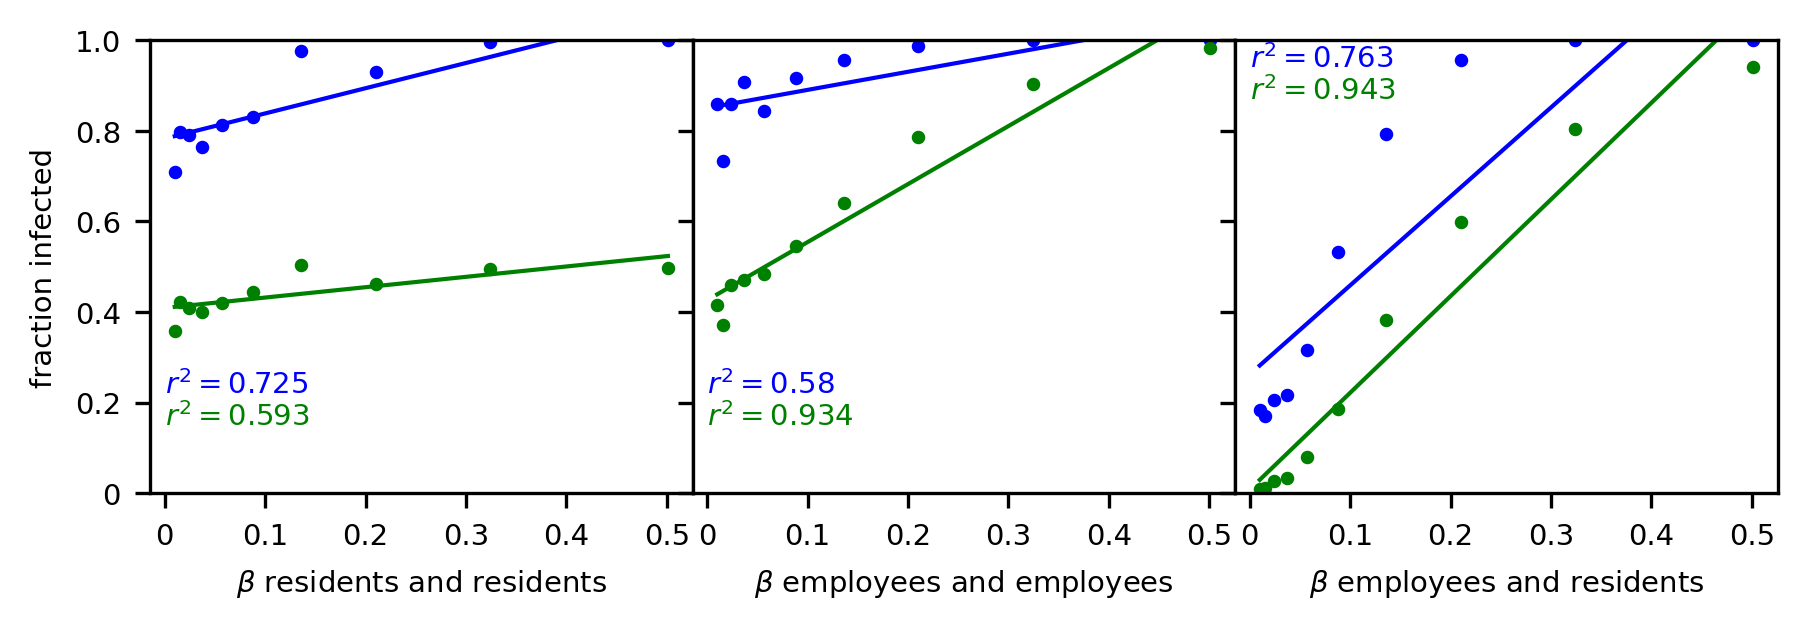

In [135]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(7, 2), dpi=300, sharey=True) 

ax1 = plot_regres(betas_ww, worker_avg_ww, client_avg_ww, ax=ax1, xpos=(0, 0), ypos=(0.22, 0.15))
ax1.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax1.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=7)
ax1.set_xlabel(r'$\beta$ residents and residents', fontsize=7)
ax1.set_yticks(np.arange(0, 1.1, 0.2))
ax1.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=7)
ax1.set_ylabel('fraction infected', fontsize=7)

ax2 = plot_regres(betas_cc, worker_avg_cc, client_avg_cc, ax=ax2, xpos=(0, 0), ypos=(0.22, 0.15))
ax2.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax2.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=7)
ax2.set_xlabel(r'$\beta$ employees and employees', fontsize=7)

ax3 = plot_regres(betas_wc, worker_avg_wc, client_avg_wc, ax=ax3, xpos=(0, 0))
ax3.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax3.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=7)
ax3.set_xlabel(r'$\beta$ employees and residents', fontsize=7)

plt.subplots_adjust(wspace=0)
plt.savefig('beta infection correlation.png', dpi=300)
plt.show()